In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange

In [2]:
os.chdir('../')

In [3]:
%%capture
from nutrition_labels.grant_tagger import GrantTagger

In [4]:
data = pd.read_csv('data/processed/training_data.csv')

(array([ 16.,   5.,   3.,   4.,  10.,  16.,  23.,  51., 114., 368., 427.,
         95.,  43.,  28.,  18.,   7.,   6.,   2.,   2.,  12.,   3.,   1.,
          2.,   2.,   4.,   9.,   2.,   1.,   1.,   4.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([  13. ,  147.4,  281.8,  416.2,  550.6,  685. ,  819.4,  953.8,
        1088.2, 1222.6, 1357. , 1491.4, 1625.8, 1760.2, 1894.6, 2029. ,
        2163.4, 2297.8, 2432.2, 2566.6, 2701. , 2835.4, 2969.8, 3104.2,
        3238.6, 3373. , 3507.4, 3641.8, 3776.2, 3910.6, 4045. , 4179.4,
        4313.8, 4448.2, 4582.6, 4717. , 4851.4, 4985.8, 5120.2, 5254.6,
        5389. , 5523.4, 5657.8, 5792.2, 5926.6, 6061. , 6195.4, 6329.8,
        6464.2, 6598.6, 6733. ]),
 <BarContainer object of 50 artists>)

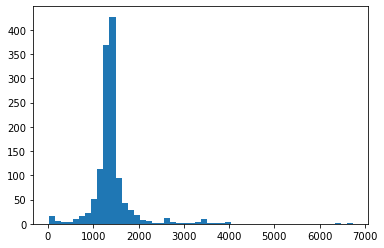

In [5]:
plt.hist(data['Description'].apply(len), bins=50)

In [ ]:
len([d for d in data['Description'] if len(d)<500])

In [6]:
def run_experiment(sample_not_relevant_range, num_repeats, vectorizer_type,model_type = 'naive_bayes'):
    experiments_results = []
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type
            )
    X_vect,y = grant_tagger.transform(data)
    for n in sample_not_relevant_range:
        average_results_train = None
        average_results_test = None
        for i in range(0, num_repeats):
            # Take the average of 5 runs

            X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                sample_not_relevant = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
            grant_tagger.fit(X_train, y_train)
            results_train = grant_tagger.evaluate(X_train, y_train, print_results=False, average='weighted')
            results_test = grant_tagger.evaluate(X_test, y_test, print_results=False, average='weighted')
            if average_results_train: # will be the same for test too
                for key in average_results_train.keys(): # will be the same for test too
                    average_results_train[key] += results_train[key]
                    average_results_test[key] += results_test[key]
            else:
                average_results_train = results_train
                average_results_test = results_test
        average_results_train = {key: value/num_repeats for key, value in average_results_train.items()}
        average_results_test = {key: value/num_repeats for key, value in average_results_test.items()}
        results_dict = {'sample_not_relevant': n}
        for key, value in average_results_train.items():
            results_dict[key+'_train'] = value
        for key, value in average_results_test.items():
            results_dict[key+'_test'] = value
        experiments_results.append(results_dict)
        
    return experiments_results

In [7]:
def plot_results(experiments_results_df):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_train',ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='accuracy_test', color='red', ax=ax1, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_train',ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='f1_test', color='red', ax=ax2, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_train',ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='precision_score_test', color='red', ax=ax3, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_train',ax=ax4, marker='.')
    experiments_results_df.plot(kind='line', x='sample_not_relevant', y='recall_score_test', color='red', ax=ax4, marker='.')
    # fig.savefig(f'sample_not_relevant_{num_repeats}reps_{vectorizer_type}.png')
    # plt.close(fig)
    plt.show()

In [8]:
count_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='count'
)

ValueError: Expected 2D array, got 1D array instead:
array=[<1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 288 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 309 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 324 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 258 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 328 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 286 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 328 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 429 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 310 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 307 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 323 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 315 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 567 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 321 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 357 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 376 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 77 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 313 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 322 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 436 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 300 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 378 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 270 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 295 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 314 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 305 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 293 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 329 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 294 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 359 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 321 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 432 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 402 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 279 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 409 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 332 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 337 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 340 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 348 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 312 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 310 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 381 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 338 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 308 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 326 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 338 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 221 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 363 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 737 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 310 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 315 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 307 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 358 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 296 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 315 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 310 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 286 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 309 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 432 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 140 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 291 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 277 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 321 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 286 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 230 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 330 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 165 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 311 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 272 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 320 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 288 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 307 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 337 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 362 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 861 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 319 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 315 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 278 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 319 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 322 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 332 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 378 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 307 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 326 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 332 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 330 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 331 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 221 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 305 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 331 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 291 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 289 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 288 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 306 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 277 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 269 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 265 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 368 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 327 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 268 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 275 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 282 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 290 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 444 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 195 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 187 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 277 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 402 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 308 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 288 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 276 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 382 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 456 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 268 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 294 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 281 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 297 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 376 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 302 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 254 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 320 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 321 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 276 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 335 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 329 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 317 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 332 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 317 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 270 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 306 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 280 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 312 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 310 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 323 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 315 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 329 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 338 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 144 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 229 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 465 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 315 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 309 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 257 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 387 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 301 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 312 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 326 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 331 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 320 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 291 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 321 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 307 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 315 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 329 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 319 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 322 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 329 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 328 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 289 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 319 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 323 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 288 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 281 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 368 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 314 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 220 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 523 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 282 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 329 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 338 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 292 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 323 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 235 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 354 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 3 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 328 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 344 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 333 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 560 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 286 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 224 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 316 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 272 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 326 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 313 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 332 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 247 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 225 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 1224 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 369 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 311 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 313 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 294 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 325 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 269 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 344 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 407 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 322 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 447 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 30 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 310 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 344 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 326 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 609 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 289 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 334 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 328 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 377 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 258 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 293 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 311 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 295 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 752 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 303 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 296 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 324 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 407 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 304 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 306 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 282 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 618 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 323 stored elements in Compressed Sparse Row format>
 <1x134424 sparse matrix of type '<class 'numpy.int64'>'
	with 113 stored elements in Compressed Sparse Row format>].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
experiments_results_df = pd.DataFrame(count_experiments_results)
plot_results(experiments_results_df)

In [ ]:
tfidf_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=10, vectorizer_type='tfidf'
)

In [ ]:
experiments_results_df = pd.DataFrame(tfidf_experiments_results)
plot_results(experiments_results_df)

In [ ]:
print(len(data.loc[data['Relevance code'] == 1]))
print(len(data.loc[data['Relevance code'] == 0]))

## Explore all the results of those with good parameters

In [ ]:
def test_setting(data, vectorizer_type, n, model_type = 'naive_bayes'):
    i = 4
    grant_tagger = GrantTagger(
                ngram_range=(1,2),
                test_size=0.25,
                vectorizer_type = vectorizer_type,
                model_type = model_type
            )
    X_vect,y = grant_tagger.transform(data)
    X_train, X_test, y_train, y_test = grant_tagger.split_data(
                X_vect,
                y,
                sample_not_relevant = n,
                irrelevant_sample_seed = i,
                split_seed=i
                )
    grant_tagger.fit(X_train, y_train)
    results_train = grant_tagger.evaluate(X_train, y_train, average='weighted')
    results_test = grant_tagger.evaluate(X_test, y_test, average='weighted')

In [ ]:
test_setting(data, 'tfidf', 40)

In [ ]:
test_setting(data, 'tfidf', 320)

In [ ]:
test_setting(data, 'count', 40)

In [ ]:
test_setting(data, 'count', 400)

## Testing Bert Vectorizer


Bert and Naive Bayes model


In [ ]:
%%capture
bert_bayes_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=5, vectorizer_type='bert'
)


In [ ]:
experiments_results_df = pd.DataFrame(bert_bayes_experiments_results)
plot_results(experiments_results_df)

Bert and SVM model


In [ ]:
%%capture
bert_svm_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=5, vectorizer_type='bert', model_type='SVM'
)


In [ ]:
experiments_results_df = pd.DataFrame(bert_svm_experiments_results)
plot_results(experiments_results_df)

Bert and Logistic regression model


In [ ]:
%%capture
bert_logreg_experiments_results = run_experiment(
    arange(0.2, 2,0.075), num_repeats=5, vectorizer_type='bert', model_type='log_reg'
)


In [ ]:
experiments_results_df = pd.DataFrame(bert_logreg_experiments_results)
plot_results(experiments_results_df)

## Exploring Bert Results with good parameters 

In [ ]:
test_setting(data, 'bert', 40)

In [ ]:
test_setting(data, 'bert', 360)

In [ ]:
test_setting(data, 'bert', 40,'SVM')

In [ ]:
test_setting(data, 'bert', 360,'SVM')

test_setting(data, 'bert', 360,'SVM')

In [ ]:
test_setting(data, 'bert', 40)

## Exploring Bert Results with good parameters 

In [ ]:
test_setting(data, 'bert', 40)

In [ ]:
test_setting(data, 'bert', 360)

In [ ]:
test_setting(data, 'bert', 40,'SVM')

In [ ]:
test_setting(data, 'bert', 360,'SVM')

test_setting(data, 'bert', 360,'SVM')

In [ ]:
test_setting(data, 'bert', 40)

In [ ]:
test_setting(data, 'bert', 360)

In [ ]:
test_setting(data, 'bert', 40,'SVM')

In [ ]:
test_setting(data, 'bert', 360,'SVM')